Create holes on a regular grid

In [165]:
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [166]:
def generate_grid_collars(grid_size, spacing, elevation, origin_x, origin_y):
    """
    Generate drillhole collars on a regular grid with a custom origin.
    
    :param grid_size: Tuple (rows, cols) defining the grid dimensions
    :param spacing: Spacing between drillholes
    :param z_min: Minimum Z value for elevation
    :param z_max: Maximum Z value for elevation
    :param origin_x: X coordinate for the origin
    :param origin_y: Y coordinate for the origin
    :return: List of dictionaries containing collar data
    """
    rows, cols = grid_size
    collars = []
    z=elevation
    for i in range(rows):
        for j in range(cols):
            drillhole_id = f'DH{i*cols + j + 1:04d}'  # Generate drillhole ID e.g., DH0001
            x = origin_x + j * spacing
            y = origin_y + i * spacing
            #z = random.uniform(z_min, z_max)
            
            collar = {
                'ID': drillhole_id,
                'X': x,
                'Y': y,
                'Z': z
            }
            collars.append(collar)
    
    return collars


In [167]:
def generate_survey_and_assay_data(collars, maxHoleLength, origin_x, background_means, background_stds, high_grade_prob, high_grade_means, high_grade_stds, gradient_factor):
    """
    Generate survey and assay data for each drillhole.
    
    :param collars: List of collar data
    :param num_intervals_min: Minimum number of intervals per drillhole
    :param num_intervals_max: Maximum number of intervals per drillhole
    :param background_means: Dictionary with mean values for background assays
    :param background_stds: Dictionary with standard deviations for background assays
    :param high_grade_prob: Probability of encountering high-grade zones
    :param high_grade_means: Dictionary with mean values for high-grade assays (for log-normal distribution)
    :param high_grade_stds: Dictionary with standard deviations for high-grade assays (for log-normal distribution)
    :param gradient_factor: Factor to apply the mineral trend in the X direction
    :return: Lists of dictionaries containing survey and assay data
    """
    surveys = []
    assays = []
    

    azimuth=10
    dip = 75

    for collar in collars:
        drillhole_id = collar['ID']
        from_depth = 0.0
        num_intervals = maxHoleLength # random.randint(num_intervals_min, num_intervals_max)
        
        x_position = collar['X']
        
        for _ in range(num_intervals):
            
            to_depth = from_depth + 1 # random.uniform(1, 50)  # Example interval length
            #azimuth = random.uniform(0, 360)  # Azimuth in degrees
            #dip = random.uniform(-90, 90)    # Dip in degrees
            
            # Survey data
            survey = {
                'ID': drillhole_id,
                'From': from_depth,
                'Azimuth': azimuth,
                'Dip': dip
            }
            surveys.append(survey)
            
            # Assay data
            if random.random() < high_grade_prob:
                # High-grade zone
                au_assay = round(random.normalvariate(high_grade_means['Au'], high_grade_stds['Au']), 2)
                cu_assay = round(random.normalvariate(high_grade_means['Cu'], high_grade_stds['Cu']), 2)
                ag_assay = round(random.normalvariate(high_grade_means['Ag'], high_grade_stds['Ag']), 2)
            else:
                # Background values
                au_assay = round(random.normalvariate(background_means['Au'], background_stds['Au']), 2)
                cu_assay = round(random.normalvariate(background_means['Cu'], background_stds['Cu']), 2)
                ag_assay = round(random.normalvariate(background_means['Ag'], background_stds['Ag']), 2)
            
            # Apply gradient factor
            au_assay += gradient_factor * (x_position - origin_x)
            cu_assay += gradient_factor * (x_position - origin_x)
            ag_assay += gradient_factor * (x_position - origin_x)
            
            cu_assay=round(random.uniform(0.01, high_grade_means['Cu']),2) if cu_assay<=0 else cu_assay
            au_assay=au_assay*(-1) if au_assay<0 else au_assay
            ag_assay=ag_assay*(-1) if ag_assay<0 else ag_assay

            assay = {
                'ID': drillhole_id,
                'From': from_depth,
                'To': to_depth,
                'Au': max(au_assay,0),  # Ensure no negative values
                'Cu': cu_assay,  # Ensure no negative values
                'Ag': ag_assay   # Ensure no negative values
            }
            assays.append(assay)
            
            from_depth = to_depth  # Set the start of the next interval to the end of the current one
    
    return surveys, assays

In [168]:
def write_data_to_csv(data, file_name, fieldnames):
    """
    Write the list of data to a CSV file.
    
    :param data: List of dictionaries containing the data
    :param file_name: Name of the CSV file
    :param fieldnames: List of fieldnames for the CSV file
    """
    with open(file_name, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)

Data has been written to collars.csv, surveys.csv, and assays.csv


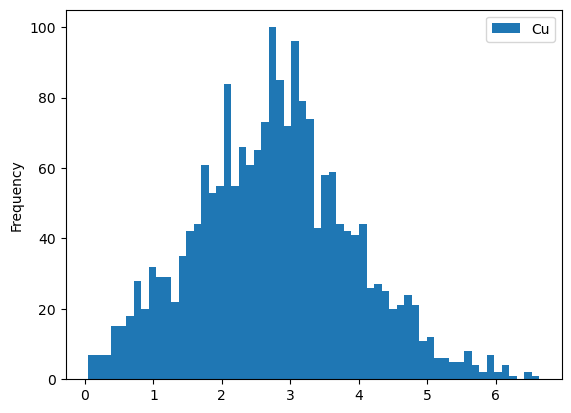

In [163]:
# Configuration
grid_size = (25, 25)  # 20 rows by 20 columns
spacing = 12.5  # 20 units spacing between drillholes
hole_length = 20 #drillhole length required

elevation = 990

origin_x = 1527734  # Custom X coordinate origin
origin_y = 725715  # Custom Y coordinate origin

gradient_factor = 0.005  # Factor to apply the mineral trend

# Mean and standard deviation for background assay values (for normal distribution)
background_means = {'Au': 0.1, 'Cu': 1.5, 'Ag': 2}
background_stds = {'Au': 0.05, 'Cu': 0.5, 'Ag': 1}

# Probability of encountering high-grade zones
high_grade_prob = 0.65  # 10% chance of a high-grade interval

# Mean and standard deviation for high-grade assay values (for log-normal distribution)
high_grade_means = {'Au': 5, 'Cu': 2.5, 'Ag': 25}
high_grade_stds = {'Au': 0.4, 'Cu': 0.5, 'Ag': 0.5}

# Generate collars on a grid with custom origin
collars = generate_grid_collars(grid_size, spacing, elevation, origin_x, origin_y)

# Generate survey and assay data
surveys, assays = generate_survey_and_assay_data(collars, hole_length, origin_x, background_means, background_stds, high_grade_prob, high_grade_means, high_grade_stds, gradient_factor)

# Write data to CSV files
write_data_to_csv(collars, 'collars.csv', ['ID', 'X', 'Y', 'Z'])
write_data_to_csv(surveys, 'surveys.csv', ['ID', 'From', 'Azimuth', 'Dip'])
write_data_to_csv(assays, 'assays.csv', ['ID', 'From', 'To', 'Au', 'Cu', 'Ag'])

print("Data has been written to collars.csv, surveys.csv, and assays.csv")

myp = df[['Cu']].plot.hist(subplots=True,bins=60)

In [164]:
#plt.subplot=True
#plt.title('Histogram : Some Element')
#plt.xlabel('Cu')
#plt.ylabel('Fregquency')
#plt.legend(('Cu'))

#cu_plt = plt.hist(df[['Cu','Au','Ag']],bins=50,label='CU',color=['grey','blue','black'])